# Machine learning - sprint 1
authors: Allart Ewoud, Van Hees Maxime, Breda Bram

#### GET AN INTIAL FEEL OF THE DATA? MOET DIT ER NOG BIJ OF NIET? --> LABO 1

## Importing data

In [1]:
# Import pandas and read csv using pandas
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import plotly.express as px

from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

In [2]:


original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")

# display the data and see how it formulated
pd.set_option("display.max_columns", None)
original_df.head()

,rank,restaurant name,general rating,number of reviews,tags,address,phone number,website url,menu url,timetable,email address,travelers choice,michelin,food rating,service rating,value rating,atmosphere rating,description,dutch description,price range,cuisines,special diets,meals,restaurant features,id
0,#1,Kin Khao - Thai Eatery,5.0 of 5 bubbles,922 reviews,$$ - $$$|Thai|Healthy|Vegetarian Friendly,"Donkersteeg 21-23, Ghent 9000 Belgium",+32 468 10 59 59,http://www.kinkhao.be/,http://www.kinkhao.be/site/menu/,True,gent@kinkhao.be,True,False,5.0,5.0,4.5,-1.0,"Differing from formal dining establishments, K...",NaN,€10 - €28,"Thai, Healthy","Vegetarian Friendly, Vegan Options, Gluten Fre...","Dinner, Drinks","Reservations, Seating, Serves Alcohol, Free Wi...",13969825
1,#1,'t Sleutelgat,5.0 of 5 bubbles,200 reviews,$$$$|French|Belgian|European,"Kasseide 78, Ninove 9400 Belgium",+32 54 56 63 09,http://www.restaurant-sleutelgat.be/,NaN,True,restaurant_sleutelgat@telenet.be,False,True,5.0,5.0,4.5,5.0,NaN,NaN,€32 - €74,"French, Belgian, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Free Wifi, Reservations, Outdoor Seating, Seat...",740727
2,#2,Royal India Restaurant,4.5 of 5 bubbles,774 reviews,$$ - $$$|Indian|Asian|Vegetarian Friendly,"Donkersteeg 19 Near hotel novotel gent, Ghent ...",+32 497 40 78 27,NaN,NaN,True,royalindiabelgium@gmail.com,True,False,4.5,4.5,4.5,-1.0,"For fresh ingredients and bold flavour, dine i...",NaN,€15 - €30,"Indian, Asian","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner, Late Night, Drinks","Takeout, Reservations, Seating, Highchairs Ava...",12188645
3,#3,Roots,5.0 of 5 bubbles,282 reviews,$$ - $$$|Belgian|European|Healthy,"Vrouwebroersstraat 5, Ghent 9000 Belgium",+32 9 310 67 73,http://www.rootsgent.be/,NaN,True,Info@rootsgent.be,True,True,5.0,4.5,5.0,-1.0,NaN,NaN,€40 - €80,"Belgian, European, Healthy",NaN,"Lunch, Dinner","Reservations, Outdoor Seating, Seating, Serves...",9710340
4,#1,Mirage,4.5 of 5 bubbles,240 reviews,$$ - $$$|French|Belgian|Dutch,"Brusselsestraat 99, Dendermonde 9200 Belgium",+32 52 55 48 26,http://mirage-ma.be/,http://mirage-ma.be/feestdagenmenus/,True,contact@mirage-ma.be,True,False,4.5,4.5,4.5,-1.0,NaN,NaN,€16 - €64,"French, Belgian, Dutch, Seafood, European","Vegetarian Friendly, Vegan Options, Gluten Fre...","Lunch, Dinner","Accepts Visa, Reservations, Outdoor Seating, S...",8298124


## Split in test & train data

The goal of machine learning is to build models on train data that are able to make predictions on unseen test data. So we first try to split our data into a trainset and a test set before we move on to the other steps.

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(original_df, random_state=0, train_size = 0.8)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df_train.select_dtypes(include=numerics)

## Data clean-up

First we start with cleaning of the less complicated data. This includes the collumns general rating, number of reviews and rank.

### General rating, number of reviews & rank

General rating komt in een tekstuele vorm, uit deze vorm moet enkel het eerste getal worden gehaald. We merken ook op dat het een aantal -1 values heeft, deze veranderen we door NaN. 



In [4]:
# general rating
df["general rating"] = df_train["general rating"].apply(lambda x: float(str(x).split(' ')[0]))
df["general rating"] = pd.to_numeric(df["general rating"])
df["general rating"] = df["general rating"].replace(-1, np.nan)

# number of reviews
df["number of reviews"] = df_train["number of reviews"].apply(lambda x: int(str(x).split(' ')[0]))
df["number of reviews"] = pd.to_numeric(df["number of reviews"])

# rank
df["rank"] = df_train["rank"].str.split("#").str[1]
df["rank"] = pd.to_numeric(df["rank"])

df.head()

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0


### Restaurants with no reviews

2 options:

- we remove the restaurants that have no reviews, and thus nu general rating. But will this impact the model we will train later on? 

```df2 = df.loc[(df['number of reviews'] == 0) & (df['general rating'] == -1.0)]```

- we don't remove them and assume the model will learn by itself that these entries aren't that useful.

Kga dit eens vragen aan iemand die data science als werk doet.

### Price range
A collumn that is a bit more complicated is price range, this collumn will be split in 2, after this the average is taken.

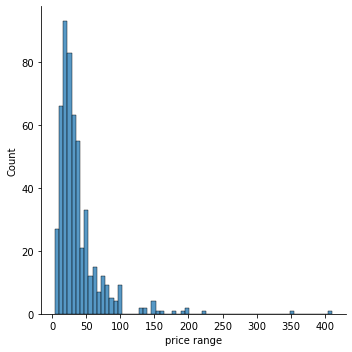

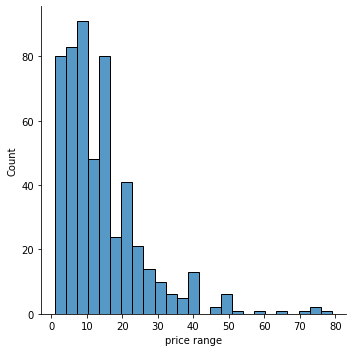

In [5]:
upper_bound = df_train["price range"].str.split(" - ").str[1]
upper_bound = upper_bound.str.split('€').str[1]
upper_bound = pd.to_numeric(upper_bound)

lower_bound = df_train["price range"].str.split(" - ").str[0]
lower_bound = lower_bound.str.split('€').str[1]
lower_bound = pd.to_numeric(lower_bound)

sn.displot(upper_bound)
sn.displot(lower_bound)

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range
220,4.0,4.0,4.0,4.0,1127788,4.0,179,119.0,0.0
1103,4.0,3.5,3.5,-1.0,12272003,3.5,79,430.0,NaN
17,4.5,4.5,4.5,4.0,784367,4.5,254,11.0,0.0
58,4.5,4.5,4.5,-1.0,8279642,4.5,120,1.0,0.0
847,4.0,4.5,4.5,-1.0,10037978,4.5,20,26.0,NaN


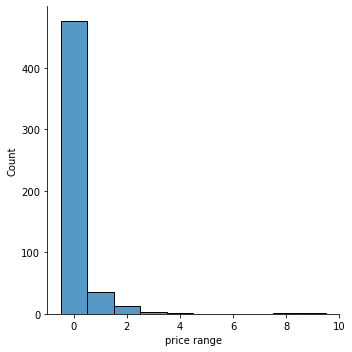

In [6]:
from sklearn import preprocessing

average = (upper_bound-lower_bound)/2

transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': 10, 'labels': 
                                                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'retbins': True})
avg_quantfied = transformer.fit_transform(average)

#visualize the data
sn.displot(avg_quantfied[0])

df['price range'] =  pd.to_numeric(avg_quantfied[0])
df.head()

### Food, service & value rating

array([[<AxesSubplot:xlabel='food rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='general rating', ylabel='food rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='general rating', ylabel='service rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='value rating'>,
        <AxesSubplot:xlabel='general rating', ylabel='value rating'>],
       [<AxesSubplot:xlabel='food rating', ylabel='general rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='general rating'>,
        <AxesSubplot:xlabel

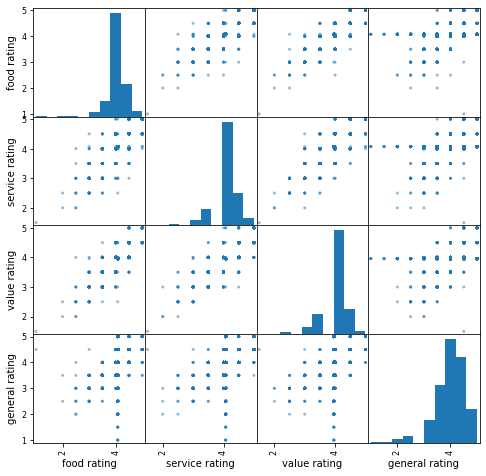

In [30]:
pd.plotting.scatter_matrix(df[["food rating","service rating","value rating", "general rating"]], figsize = (8,8))

Notice in the chart above, that in food rating, service rating, value rating & atmosphere rating there are alot of -1.
- In the cases of food, value & service rating we are going to replace them with the average
- In the case of atmosphere rating, we are going to drop this column, you can see that most of the data here is -1. So in this case this looks like the best solution.

In [31]:
mean = df["service rating"].loc[df["service rating"] != -1].mean()
df["service rating"] = df["service rating"].replace(-1,mean)

mean = df["food rating"].loc[df["food rating"] != -1].mean()
df["food rating"] = df["food rating"].replace(-1,mean)

mean = df["value rating"].loc[df["value rating"] != -1].mean()
df["value rating"] = df["value rating"].replace(-1,mean)

df = df.drop(columns=["atmosphere rating"])

pd.plotting.scatter_matrix(df[["food rating","service rating","value rating"]], figsize = (8,8))

KeyError: "['atmosphere rating'] not found in axis"

### Meals

In [9]:
# Getting all different types off meals
types = []
for i in df_train['meals'].fillna(value=""):
    types.extend(map(lambda x: x.strip(), i.split(",")))
types = set(types)


# For every type we are going to create a collumn that represents the type
for i in types:
    if i != "":
        df[i] = df_train["meals"].apply(lambda x: str(x)).apply(lambda x: int(i in x))

# displays full table
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): display(df)
df.head()

,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range,Dinner,Brunch,Breakfast,Late Night,Drinks,Lunch
220,4.0,4.0,4.0,4.000000,1127788,4.0,179,119.0,0.0,1,0,0,1,0,1
1103,4.0,3.5,3.5,3.860494,12272003,3.5,79,430.0,NaN,1,0,0,0,0,0
17,4.5,4.5,4.5,4.000000,784367,4.5,254,11.0,0.0,1,0,0,0,0,0
58,4.5,4.5,4.5,3.860494,8279642,4.5,120,1.0,0.0,1,0,0,0,0,1
847,4.0,4.5,4.5,3.860494,10037978,4.5,20,26.0,NaN,1,0,0,0,0,0


#### <font color='red'>VRAAG: kunnen we de opties reduceren, bv brunch & breakfast? Later hiernaar kijken</font>

### Cuisines

In [10]:
types = []
for i in df_train['cuisines'].fillna(value=""):
    types.extend(map(lambda x: x.strip(), i.split(",")))
types = set(types)
print("Amount of different cuisines:",len(types))

# prints the amout of times a cuisine occurs in the data
# set _print on True to enable printing of frequencies
_print = True


freq = {}
for i in types:  
    if i != "":
        freq[i] = df_train["cuisines"].apply(lambda x: str(x)).apply(lambda x: int(i in x)).sum()


#print("\n")
#print("-"*20, "frequency tabel", "-"*20) 
#for key, value in freq.items():
#    print('{:<25}'.format(key ), '{:>4}'.format(value) , "times")
percentile75 = np.quantile(list(freq.values()), 0.75)
percentile50 = np.quantile(list(freq.values()), 0.5)

print("50-percentile:",percentile50)
print("75-percentile:",percentile75)


freq = { key:value for (key,value) in freq.items() if value > percentile50}

for (key,value) in freq.items():
    if key != "":
        df[key] = df_train["cuisines"].apply(lambda x: int(key in str(x)))
   
#TODO add others collumn
df

Amount of different cuisines: 93
50-percentile: 6.0
75-percentile: 37.5


,food rating,service rating,value rating,atmosphere rating,id,general rating,number of reviews,rank,price range,Dinner,Brunch,Breakfast,Late Night,Drinks,Lunch,Barbecue,International,Steakhouse,Cafe,Dutch,American,Vietnamese,Grill,Street Food,French,Fast Food,Thai,Central European,Mediterranean,Sushi,Seafood,Pizza,Contemporary,Healthy,Wine Bar,Southern-Italian,Asian,Japanese,Fusion,Gastropub,Mexican,Indian,Bar,South American,Italian,Deli,Sicilian,Middle Eastern,Soups,Pub,European,Greek,Diner,Turkish,Japanese Fusion,Chinese,Spanish,Dining bars,Lebanese,Belgian
220,4.000000,4.000000,4.000000,4.000000,1127788,4.0,179,119.0,0.0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1103,4.000000,3.500000,3.500000,3.860494,12272003,3.5,79,430.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
17,4.500000,4.500000,4.500000,4.000000,784367,4.5,254,11.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58,4.500000,4.500000,4.500000,3.860494,8279642,4.5,120,1.0,0.0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
847,4.000000,4.500000,4.500000,3.860494,10037978,4.5,20,26.0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,4.000000,4.500000,4.000000,3.860494,14107034,4.0,19,1.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1731,4.077579,4.071197,3.959241,3.860494,14051083,3.5,9,587.0,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
763,4.000000,4.000000,3.500000,4.000000,3820132,3.5,101,4.0,NaN,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
835,4.000000,3.500000,4.000000,4.500000,3614874,4.0,107,41.0,NaN,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


The boxplot shows the distribution of the frequencies of the cuisines. Here we can see that a lot of cuisines occur only a few times. This may presents an oppertunity to reduce these to a categorie like "others".

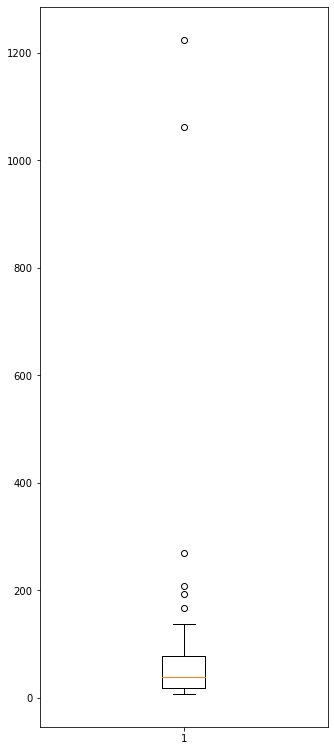

In [11]:
fig = plt.figure(figsize =(4, 10))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(freq.values())
plt.show()  

### Address

The address field has the following structure in most cases:
    1. Streetname + number + ","
    2. City + corresponding postal code
    3. Country (here Belgium in all cases)
Upon closer inspection we can see that sometimes field 1. and 2. are comma-separted, sometimes not.
The number behind the streetname sometimes consists of two numbers (can be split with ' ' or '-' or '/' or ...)

In [12]:
locator = Nominatim(user_agent="ML")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

def get_coordinates(name):
    location = locator.geocode(name)
    if location is None:
        return pd.Series([np.nan, np.nan])
    else:
        return pd.Series([location.latitude, location.longitude])
    
df[['latitude','longitude']] = df_train['address'].fillna('').apply(get_coordinates)
df


KeyboardInterrupt



In [ ]:
fig = px.scatter_mapbox(df[['latitude', 'longitude']], lat="latitude", lon="longitude", height=500, width=700)

fig.update_layout(mapbox_style="open-street-map")
fig.show()
# https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6

### Restaurant features

Extract different restaurant feautures from the dataset

Amount of features: 39


<AxesSubplot:>

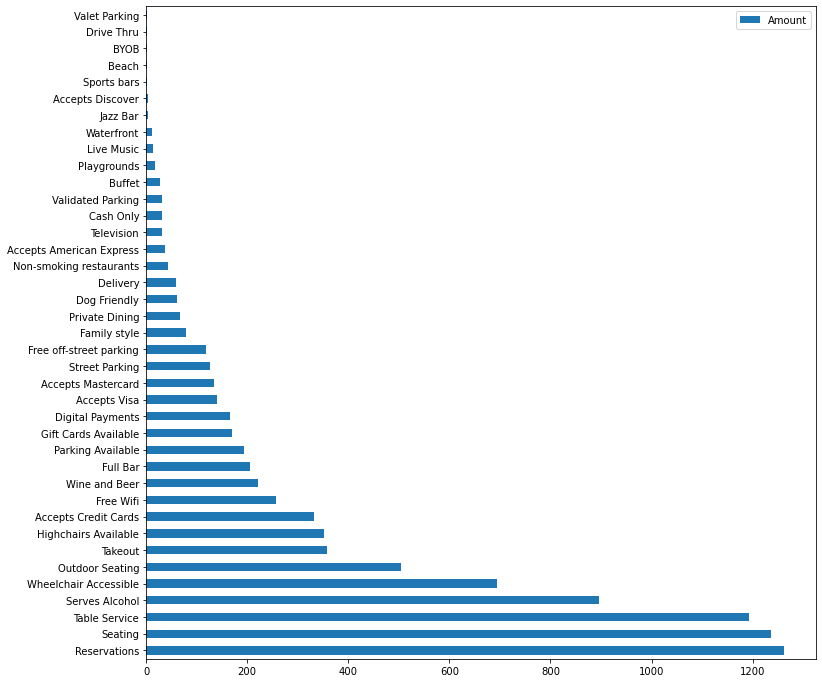

In [13]:
# Create a dict that holds all restaurant feautures and how much they appear
feature_types = {}
for i in df_train['restaurant features'].fillna(value=""):
    for f in i.split(','):
        if i != "":
            if f.strip() in feature_types.keys():
                feature_types[f.strip()] += 1
            else:
                feature_types[f.strip()] = 1
           
print("Amount of features:" , len(feature_types.keys()))

# omzetten naar dataframe
df_features = pd.DataFrame(feature_types, index=[0]).transpose()
df_features.columns = ['Amount']
df_features.sort_values(['Amount'], ascending=False, inplace=True)
df_features.plot(kind='barh', figsize=(12,12))

### Special Diets

Amount of diets: 5
{'Vegetarian Friendly': 685, 'Vegan Options': 167, '': 1366, 'Gluten Free Options': 145, 'Halal': 4}
Average review score per diet type {'Vegetarian Friendly': 4.086131386861314, 'Vegan Options': 4.254491017964072, '': 4.086676217765043, 'Gluten Free Options': 4.2620689655172415}


<AxesSubplot:title={'center':'Average review score per diet'}>

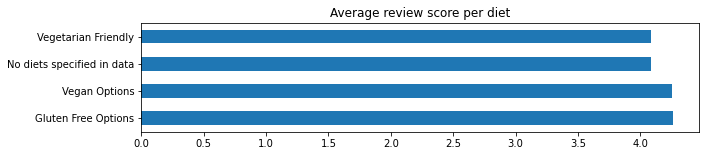

In [14]:
# check which special diets exist in the data
diet_types = {}
for i in df_train['special diets'].fillna(value=""):
    for f in i.split(','):
            if f.strip() in diet_types.keys():
                diet_types[f.strip()] += 1
            else:
                diet_types[f.strip()] = 1
           
print("Amount of diets:" , len(diet_types.keys()))
print(diet_types)

# check if available diet options have influence on the average rating per restaurant
diet_avg_review = {}
for d in diet_types.keys():
    if len(df_train[df_train['special diets'].str.contains(d) == True]) >=  100: #only use data of a diet type if there are more than 100 restaurants with that diet type
        diet_avg_review[d] = df[df_train['special diets'].str.contains(d) == True]['general rating'].mean()
print('Average review score per diet type',diet_avg_review)
df_diets = pd.Series(diet_avg_review).rename({'': 'No diets specified in data'})
df_diets.sort_values(ascending=False).plot(kind='barh', figsize=(10,2), title='Average review score per diet')


The graph above shows that restaurants with vegan and gluten free options have a higher average review score. 

### Price tag

Bij price de andere price metriek zagen we dat er zeer veel data ontbrak, de andere metriek heeft ook een aantal nadelen, het is namelijk zo dat 1 goedkoop gericht op 1 door gerecht in een resto de volleige metriek beinvoeld.

In [15]:
price_options = []

for i in df_train['tags'].fillna(value=""):
    for j in i.split('|'):
        if '$' in j:
            price_options.append(j)
            
price_options = set(price_options)
price_options = sorted(price_options, key= lambda x: len(x.split('-')[0].strip()))
       
def formatPriceRange(tags):
    for i in reversed(range(0,3)):
        if price_options[i] in tags:
            return i + 1
    return nan
       
df["price tag"] = df_train['tags'].apply(lambda x: formatPriceRange(str(x)))

### Website & menu

<AxesSubplot:title={'center':'Average score based on urls'}>

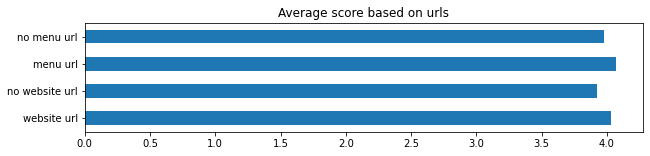

In [16]:
df['has website url'] = df_train['website url'].apply(lambda x: str(x) != "nan")
df['has menu url'] = df_train['menu url'].apply(lambda x: str(x) != "nan")

means = {}
means['website url'] = df.loc[df['has website url'] == 1]['general rating'].mean()
means['no website url'] = df.loc[df['has website url'] == 0]['general rating'].mean()

means['menu url'] = df.loc[df['has menu url'] == 1]['general rating'].mean()
means['no menu url'] = df.loc[df['has menu url'] == 0]['general rating'].mean()
pd.Series(means).plot(kind='barh', figsize=(10,2), title='Average score based on urls')

### michelin & travelers choice & timetable

De data is duidelijk gewoon een boolean, dit is eenvoudig om te zetten naar een int.

In [17]:
print(df_train['michelin'].value_counts())
print(df_train['travelers choice'].value_counts())
print(df_train['timetable'].value_counts())

df["michelin"] = df_train["michelin"].astype(int)
df["travelers choice"] = df_train["travelers choice"].astype(int)
df["timetable"] = df_train["timetable"].astype(int)

False    1987
True       77
Name: michelin, dtype: int64
False    2017
True       47
Name: travelers choice, dtype: int64
True     1141
False     923
Name: timetable, dtype: int64


### Phone number and Email address

In [18]:
print("Telefoonnummer aanwezig?")
print(df_train['phone number'].fillna('').astype(bool).value_counts())
print("Emailadres aanwezig?")
print(df_train['email address'].fillna('').astype(bool).value_counts())

df['phone number'] = df_train['phone number'].fillna('').astype(bool).astype(int)
df['email address'] = df_train['email address'].fillna('').astype(bool).astype(int)

Telefoonnummer aanwezig?
True     1888
False     176
Name: phone number, dtype: int64
Emailadres aanwezig?
True     1077
False     987
Name: email address, dtype: int64


### Tags 

Check if there is data in the tags column that is not already in other columns (excluding the price tag, because we already covered that)

In [19]:
# split and strip cuisines (,)
# split and strip special diets (,)
# split and strip tags (|)
columnsToAdd = []
def testRow(cuisines, specialDiets, tags):
    storedData = []
    # voeg eerst alles toe dat al is opgeslagen door de cuisines en special diets kolommen te verwerken
    for i in str(cuisines).split(','):
        if (i != 'nan'):
            storedData.append(i.strip())  
    for i in str(specialDiets).split(','):
        if (i != 'nan'):
            storedData.append(i.strip()) 
    
    # chech of alles in de tags kolom al is opgeslagen        
    for i in str(tags).split('|'):
        if('$' not in i):
            if(i not in storedData and i != 'nan'):
                columnsToAdd.append(i.strip())
                print('Fout bij tag:', i, tags)
                
    
df_train[['cuisines','special diets','tags']].apply(lambda x: testRow(*x), axis=1)

columnsToAdd = set(columnsToAdd)

print(columnsToAdd)

# er blijken nog enkele kolommen te ontbreken in onze df dataframe, er staat dus soms data in de tags kolom die nergens anders staat in de rij van een bepaald element

# de kolommen die ontbraken in df toevoegen

def addColumnValues(cuisines, specialDiets, tags, column):
    if (column in (str(tags).split('|') or str(cuisines).split(',') or str(specialDiets).split())):
        return 1
    return 0
for i in columnsToAdd:
    df[i] = df_train[['cuisines','special diets','tags']].apply(lambda x: addColumnValues(*x,i), axis=1)

Fout bij tag: Hong Kong $$ - $$$|Healthy|Street Food|Hong Kong
Fout bij tag: Szechuan $$ - $$$|Chinese|Asian|Szechuan
Fout bij tag: International $$ - $$$|Japanese|International|Asian
Fout bij tag: Asian $$ - $$$|Japanese|International|Asian
Fout bij tag: Quick Bites $|Quick Bites|Healthy|Vegetarian Friendly
Fout bij tag: Cantonese $$ - $$$|Chinese|Asian|Cantonese
Fout bij tag: Cantonese $|Chinese|Cantonese|Szechuan
Fout bij tag: Szechuan $|Chinese|Cantonese|Szechuan
Fout bij tag: Szechuan $$ - $$$|Chinese|Asian|Szechuan
Fout bij tag: Quick Bites $$ - $$$|Quick Bites|Mexican
Fout bij tag: Szechuan $|Chinese|Asian|Szechuan
Fout bij tag: Cantonese $$ - $$$|Chinese|Cantonese
Fout bij tag: Shanghai $$ - $$$|Chinese|Asian|Shanghai
Fout bij tag: Cantonese $|Chinese|Cantonese
{'Cantonese', 'International', 'Asian', 'Hong Kong', 'Quick Bites', 'Shanghai', 'Szechuan'}


## Data analysis

### michelin

- To start off, the ratings are checked to make sure there are no negative values. We do this cause negative values could influence the results.
- Subsequently we look at what michelin means in terms of ratings.

---------- Amount of negative values : ----------
food rating 0
atmosphere rating 0
general rating 0
value rating 0
service rating 0


<AxesSubplot:title={'center':'average ratings based on michelin'}>

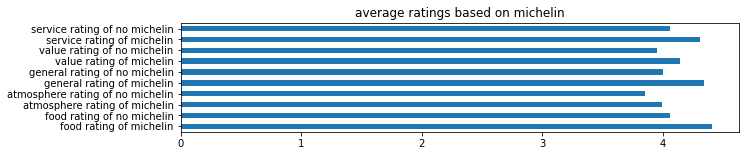

In [20]:
ratings = {"general rating", "food rating", "service rating", "value rating"}

print('-'*10,"Amount of negative values :",'-'*10)
for i in ratings:
    print(i,df[i].loc[df[i] < 0].count())
    


avg_ratings = {}

for i in ratings:
    avg_ratings[i + ' of michelin'] = df.loc[df['michelin'] == 1][i].mean()
    avg_ratings[i + ' of no michelin'] = df.loc[df['michelin'] == 0][i].mean()
    
pd.Series(avg_ratings).plot(kind='barh', figsize=(10,2), title='average ratings based on michelin')

Notice in the chart above, that michelin restaurants on average score higher. It is here important to note that we do not conclude that a michelin restaurant will give a restaurant higher ratings. It is rather so that only very good restaurants become michelin restaurants an so logicly they recuived on average higher ratings.

### Timetable

<AxesSubplot:title={'center':'average ratings based on timetables'}>

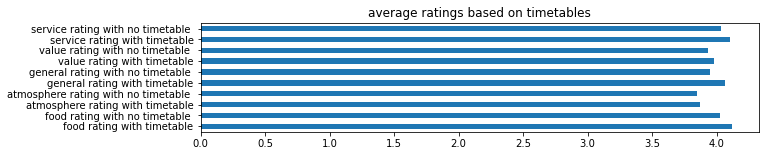

In [21]:
avg_ratings = {}
for i in ratings:
    avg_ratings[i + ' with timetable'] = df.loc[df['timetable'] == 1][i].mean()
    avg_ratings[i + ' with no timetable '] = df.loc[df['timetable'] == 0][i].mean()
    
pd.Series(avg_ratings).plot(kind='barh', figsize=(10,2), title='average ratings based on timetables')

Notice in the chart above, that on average restaurants with a timetable score higher. Het is belangrijk om te beseffen dat dit niet aanzien wordt als een factor die de ratings direct beinvloed. Er zijn kunnen verschillende redenen waarom restaurants die timetables gebruiken hoger scoren. Dit kan bijvoorbeeld een teken zijn van profesionaliteit en profesionaliteit kan leiden tot betere scores.

### travelers choice

<AxesSubplot:title={'center':'average ratings based on travelers choice'}>

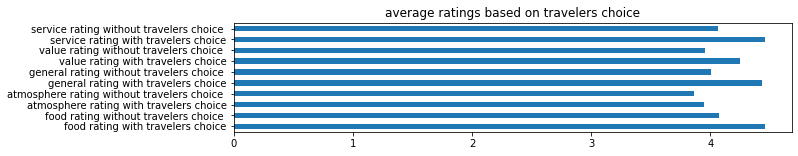

In [22]:
avg_ratings = {}
for i in ratings:
    avg_ratings[i + ' with travelers choice'] = df.loc[df['travelers choice'] == 1][i].mean()
    avg_ratings[i + ' without travelers choice '] = df.loc[df['travelers choice'] == 0][i].mean()
    
pd.Series(avg_ratings).plot(kind='barh', figsize=(10,2), title='average ratings based on travelers choice')

We zien dat restaurants die gemarkeerd zijn met travelers choice gemiddeld gezien hoger scoren.

### Ratings

<AxesSubplot:>

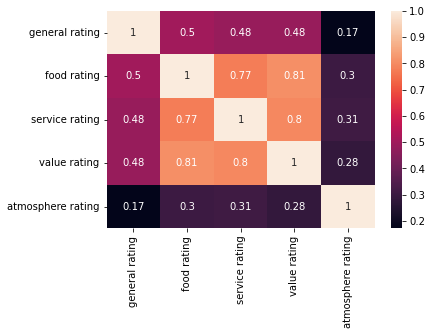

In [23]:
sn.heatmap(df[["general rating", "food rating", "service rating", "value rating"]].corr(), annot=True)

Notice in the chart above the red colering, this indicates a that food rating, value rating and service rating are highly correlated(0,7 - 0,9). At last you can notice that general rating is low(0,3 - 0,5) to moderately(0,5 - 0,7) correlated to the other ratings.

### ratings compared to price

<AxesSubplot:>

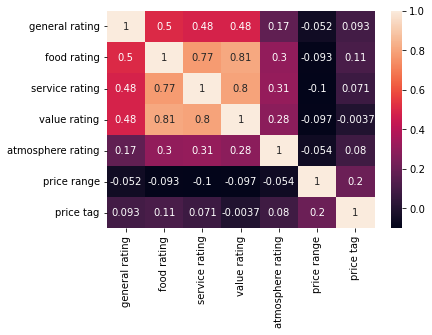

In [24]:
sn.heatmap(df[["general rating", "food rating", "service rating"
               , "value rating",'price range','price tag']].corr(), annot=True)

In the chart above you can notice that there isn't a significant correlation between the price and the rating of a restaurant.

<AxesSubplot:>

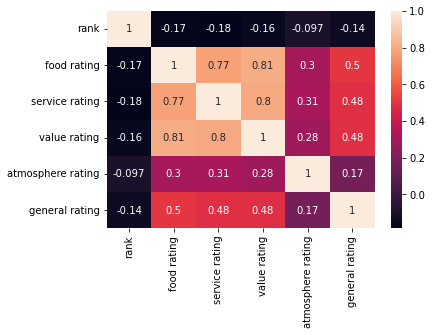

In [25]:
sn.heatmap(df[["rank", "food rating", "service rating"
               , "value rating",'general rating']].corr(), annot=True)

array([[<AxesSubplot:xlabel='rank', ylabel='rank'>,
        <AxesSubplot:xlabel='food rating', ylabel='rank'>,
        <AxesSubplot:xlabel='service rating', ylabel='rank'>,
        <AxesSubplot:xlabel='value rating', ylabel='rank'>,
        <AxesSubplot:xlabel='atmosphere rating', ylabel='rank'>,
        <AxesSubplot:xlabel='general rating', ylabel='rank'>],
       [<AxesSubplot:xlabel='rank', ylabel='food rating'>,
        <AxesSubplot:xlabel='food rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='value rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='atmosphere rating', ylabel='food rating'>,
        <AxesSubplot:xlabel='general rating', ylabel='food rating'>],
       [<AxesSubplot:xlabel='rank', ylabel='service rating'>,
        <AxesSubplot:xlabel='food rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='service rating', ylabel='service rating'>,
        <AxesSubplot:xlabel='valu

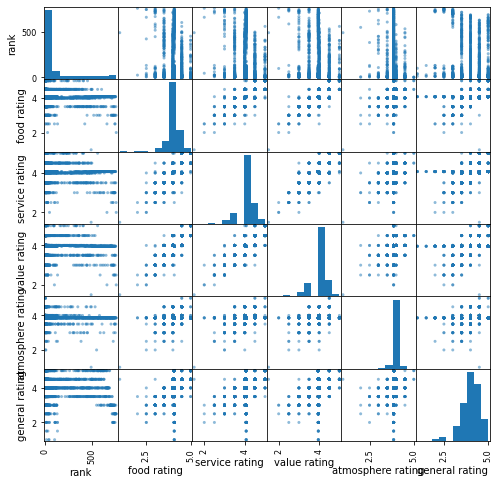

In [26]:
pd.plotting.scatter_matrix(df[["rank", "food rating", "service rating"
               , "value rating", "atmosphere rating",'general rating']], figsize = (8,8))